In [120]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from autora.theorist.bms import BMSRegressor
from gplearn.genetic import SymbolicRegressor
from kan import KAN
from sklearn.metrics import mean_squared_error, r2_score

# Comparison of Symbolic Regression using Genetic Programming and Kolmogorov-Arnold Networks (KAN)

In this notebook, we will compare three **symbolic regression** techniques for learning this simple mathematical function:

$$
y = x^2 + x + 1
$$

1. **Genetic Programming**: We will use the **gplearn** library, which implements genetic programming, to find a symbolic representation of the function \( y = x^2 + x + 1 \) using evolutionary techniques.
   
2. **Kolmogorov-Arnold-Networks (KAN)**: We will train a KAN using the official **PyKAN** library, to perform symbolic regression.

3. **Bayesian Symbolic Regression (BSR)**: We will use the [autora](https://pypi.org/project/autora/) library to solve the symbolic regression task using the Bayesian approach.


## Dataset definition and plotting

In [88]:
# Function to create dataset
def create_dataset(function, n_var, ranges, train_num=5000, test_num=1000, noise_level=5, normalize_label=True,
                   normalize_input=True):
    # Training data
    X_train = torch.linspace(ranges[0], ranges[1], train_num).view(-1, 1)
    y_train = function(X_train)

    # Adding Gaussian noise to training data
    noise_train = torch.tensor(np.random.normal(0, noise_level, X_train.shape), dtype=torch.float32)
    y_train += noise_train

    # Test data
    X_test = torch.linspace(ranges[0], ranges[1], test_num).view(-1, 1)
    y_test = function(X_test)

    # Adding Gaussian noise to test data
    noise_test = torch.tensor(np.random.normal(0, noise_level, X_test.shape), dtype=torch.float32)
    y_test += noise_test

    # Normalization
    # if normalize_input:
    #     X_train = (X_train - X_train.mean()) / X_train.std()
    #     X_test = (X_test - X_test.mean()) / X_test.std()
    # if normalize_label:
    #     y_train = (y_train - y_train.mean()) / y_train.std()
    #     y_test = (y_test - y_test.mean()) / y_test.std()

    dataset = {
        "train_input": X_train, "train_label": y_train,
        "test_input": X_test, "test_label": y_test
    }
    return dataset


quadratic_function = lambda x: x ** 2 + x + 1
dataset = create_dataset(quadratic_function, n_var=1, ranges=[-10, 10], train_num=1000, test_num=500, noise_level=14,
                         normalize_label=True, normalize_input=True)

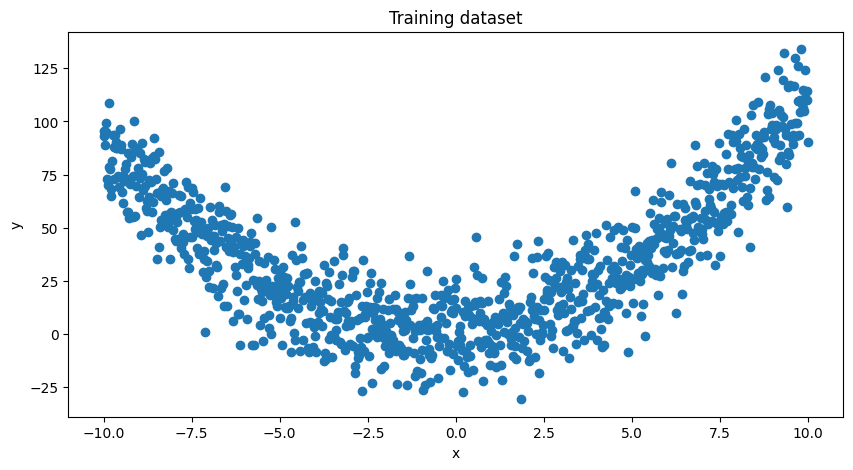

In [89]:
fig, ax = plt.subplots()
ax.scatter(dataset["train_input"].cpu(), dataset["train_label"].cpu())
fig.set_size_inches(10, 5)
plt.title('Training dataset')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Training with KAN

In [96]:
model = KAN(width=[1, 1], grid=3, k=3)
model.fit(dataset, opt="LBFGS", steps=20, lamb=0.001, lamb_entropy=4)
pass

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.38e+01 | test_loss: 1.45e+01 | reg: 6.87e+00 | : 100%|█| 20/20 [00:00<00:00, 26.40it

saving model version 0.1


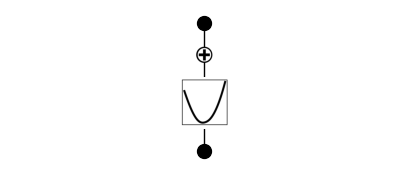

In [97]:
model.plot()

In [91]:
model.suggest_symbolic(0, 0, 0)

   function  fitting r2    r2 loss  complexity  complexity loss  total loss
0       x^2    0.999674 -11.539091           2                2   -0.707818
1       sin    0.999673 -11.536023           2                2   -0.707205
2       cos    0.999671 -11.525845           2                2   -0.705169
3         0    0.000000   0.000014           0                0    0.000003
4  gaussian    0.999665 -11.501208           3                3    0.099758


('x^2',
 (<function kan.utils.<lambda>(x)>,
  <function kan.utils.<lambda>(x)>,
  2,
  <function kan.utils.<lambda>(x, y_th)>),
 0.9996739625930786,
 2)

In [92]:
model.fix_symbolic(0, 0, 0, 'x^2')

r2 is 0.9996739625930786
saving model version 0.2


tensor(0.9997)

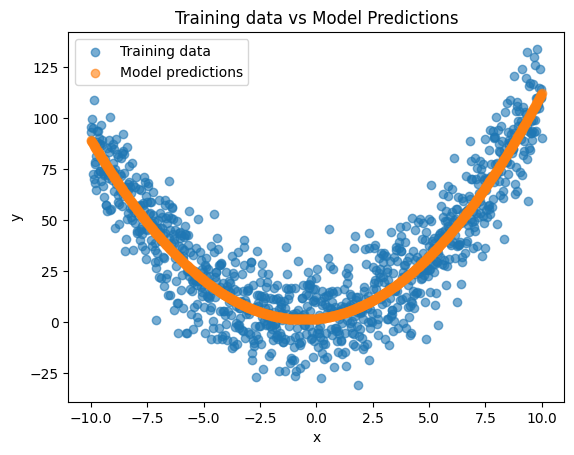

In [93]:
# Get the model predictions on the training input
with torch.no_grad():
    predictions = model(dataset['train_input'])

# Plot
fig, ax = plt.subplots()
ax.scatter(dataset['train_input'].cpu(), dataset['train_label'].cpu(), label='Training data', alpha=0.6)
ax.scatter(dataset['train_input'].cpu(), predictions.cpu(), label='Model predictions', alpha=0.6)

plt.title('Training Data vs KAN Predictions')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


1.0*(-x - 0.5)**2 + 0.7

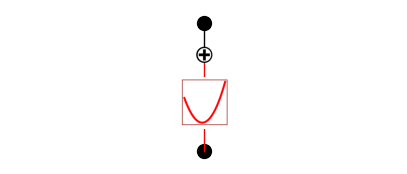

In [45]:
model.plot()

formula, variables = model.symbolic_formula(var=['x'])
formula[0].evalf(1)

## Train with Genetic Programming

In [110]:
X_train = dataset['train_input'].numpy()
y_train = dataset['train_label'].view(1000, ).numpy()

In [111]:
# Configuration of the symbolic regressor
est = SymbolicRegressor(
    population_size=2000,
    generations=50,
    tournament_size=30,
    stopping_criteria=0.01,
    const_range=(-1.0, 1.0),
    p_crossover=0.7,
    p_subtree_mutation=0.1,
    p_hoist_mutation=0.1,
    p_point_mutation=0.1,
    max_samples=0.9,
    verbose=1,
    parsimony_coefficient=0.01,
    random_state=0
)

In [112]:
est.fit(X_train, y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    46.41           398248        7          10.8801          13.0414      1.65m
   1    25.90          129.514        7          10.9455          12.8824      1.08m
   2    11.63          195.952        9          10.8747          13.0199     49.40s
   3     7.94          34.3129        9          10.8531          13.0765     43.92s
   4     7.29          38.8591        7           10.787            14.24     42.50s
   5     7.05          30.7319        7          10.7957          13.6756     41.44s
   6     6.99          62.1476        7          10.8113          13.6696     40.41s
   7     6.83          33.4685        9          10.8221          13.6544     38.80s
   8     7.10          441.736        7          10.7797          13.9454  

SymbolicRegressor(generations=50, max_samples=0.9, p_crossover=0.7,
                  p_hoist_mutation=0.1, p_point_mutation=0.1,
                  p_subtree_mutation=0.1, parsimony_coefficient=0.01,
                  population_size=2000, random_state=0, stopping_criteria=0.01,
                  tournament_size=30, verbose=1)

In [119]:
import sympy as sp

# Convert the best program to a SymPy expression
expr = est._program
variables = sp.symbols('X')  # 'X' is the input variable
sympy_expr = sp.sympify(str(expr))
sympy_expr

add(mul(X0, X0), add(0.832, add(X0, 0.849)))

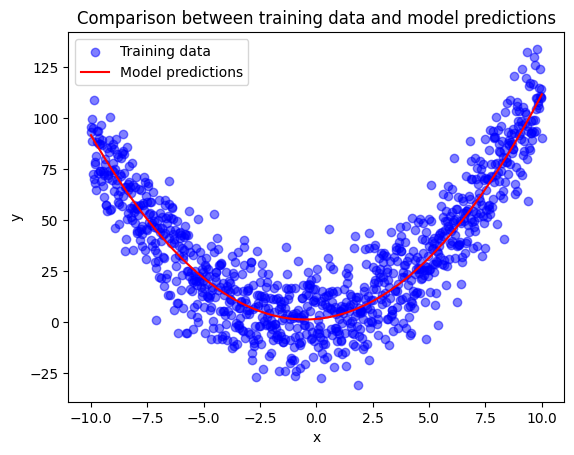

In [113]:
# Model predictions on the training data
y_pred = est.predict(X_train)

# Plot
fig, ax = plt.subplots()
ax.scatter(X_train, y_train, color='blue', label='Training data', alpha=0.5)
sorted_idx = np.argsort(X_train[:, 0])
ax.plot(X_train[sorted_idx], y_pred[sorted_idx], color='red', label='Model predictions')

plt.title('Training Data vs gplearn Predictions')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
`

In [46]:
print('Formula:', est._program)

Formula: add(mul(add(0.191, X0), X0), -0.991)


In [45]:
# Mean Squared Error
mse = mean_squared_error(y_train, y_pred)

# R^2 coefficient of determination
r2 = r2_score(y_train, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Coefficient of Determination (R^2): {r2}")

Errore Quadratico Medio (MSE): 0.03185133195076117
Coefficiente di Determinazione (R^2): 0.9681422957917769


## Train with BSR Regressor

In [58]:
X_train = dataset['train_input'].numpy()
y_train = dataset['train_label'].numpy()

In [122]:
temperatures = [1.0] + [1.04 ** k for k in range(1, 20)]

bms_estimator = BMSRegressor(
    epochs=100,
    ts=temperatures,
)

In [123]:
bms_estimator.fit(X_train, y_train)

INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 500/500 [00:35<00:00, 14.01it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


((X0 + _a0_) ** 2)

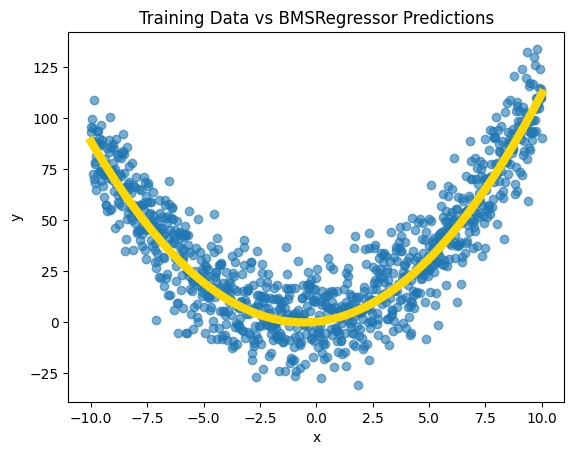

In [145]:
y_pred = bms_estimator.predict(X_train)
plt.figure()
plt.title('Training Data vs BMSRegressor Predictions')
plt.plot(X_train, y_train, "o",alpha=0.6, )
plt.plot(X_train, y_pred, "-", linewidth=6, color='gold')
plt.xlabel('x')
plt.ylabel('y')
bms_estimator.model_